# Setup

In [1]:
# import your standard packages
%run ../../../global_tools/start.py

# import your local functions
sys.path.insert(1, '../../code/')
from local_functions import *

# make sure the figures plot inline rather than at the end
%matplotlib inline


Default libraries loaded.


# Paths and Parameters

In [2]:
outfn = '../../data/chl_to_woa.nc'

# Read Data

In [3]:
# SLA
ds_CHL = xr.open_dataset('../../data/chl_processed.nc')
ds_CHL

<xarray.Dataset>
Dimensions:           (lat: 828, lon: 1296, month: 12, time: 273)
Coordinates:
  * lon               (lon) float64 48.52 48.56 48.6 48.65 ... 102.4 102.4 102.5
  * lat               (lat) float64 -1.479 -1.438 -1.396 ... 32.9 32.94 32.98
  * time              (time) datetime64[ns] 1997-09-04 1997-10-01 ... 2020-05-01
  * month             (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    mon_chl           (time, lat, lon) float64 ...
    mon_chl_mon_clim  (month, lat, lon) float64 ...
    mon_chl_mon_anom  (time, lat, lon) float64 ...

In [4]:
# WOA
infn_WOA = '../../data/woa_processed.nc'

ds_WOA = xr.open_dataset(infn_WOA)
ds_WOA

<xarray.Dataset>
Dimensions:                      (coastal_loc: 1925, depth: 57, lat: 35, lon: 55, lonmin,lonmax,latmin,latmax: 4, month: 12)
Coordinates:
  * month                        (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * depth                        (depth) float32 0.0 5.0 10.0 ... 1450.0 1500.0
  * lon                          (lon) float32 48.5 49.5 50.5 ... 101.5 102.5
  * lat                          (lat) float32 -1.5 -0.5 0.5 ... 30.5 31.5 32.5
  * coastal_loc                  (coastal_loc) int64 0 1 2 3 ... 1922 1923 1924
  * lonmin,lonmax,latmin,latmax  (lonmin,lonmax,latmin,latmax) int64 0 1 2 3
Data variables:
    temp                         (month, depth, lat, lon) float64 ...
    psal                         (month, depth, lat, lon) float64 ...
    doxy                         (month, depth, lat, lon) float64 ...
    nitrate                      (month, depth, lat, lon) float64 ...
    phosphate                    (month, depth, lat, lon) float64 ...
    pres  

# Process

In [5]:
xx,yy = np.meshgrid(ds_CHL.lon,ds_CHL.lat)
xx = xx.flatten()
yy = yy.flatten()

xx_WOA,yy_WOA = np.meshgrid(ds_WOA.lon,ds_WOA.lat)

mon_chl_mon_clim_WOA = np.zeros((len(ds_WOA.month),len(ds_WOA.lat),len(ds_WOA.lon)))*np.nan

for tt in tqdm(range(len(ds_WOA.month))):

    temp_sla = np.array(ds_CHL.mon_chl_mon_clim[tt,:,:])

    # find the lons and lats of TCD vals at this time

    points = np.array( (xx,yy) ).T
    temp_values = temp_sla.flatten()

    mon_chl_mon_clim_WOA[tt,:,:] = griddata(points, temp_values, (xx_WOA,yy_WOA) ,method='linear')

ds_out = xr.Dataset(coords={'month': ds_WOA.month,
                        'lon': ds_WOA.lon,
                        'lat': ds_WOA.lat})
coords = [ds_WOA.month,ds_WOA.lat,ds_WOA.lon]
dims = ['month','lat','lon']

# add to dataset
ds_out['mon_chl_mon_clim'] = xr.DataArray(mon_chl_mon_clim_WOA,dims = dims,coords = coords)



100%|██████████| 12/12 [04:51<00:00, 22.76s/it]


# Sample Plot

Text(0.5, 1.0, 'Original')

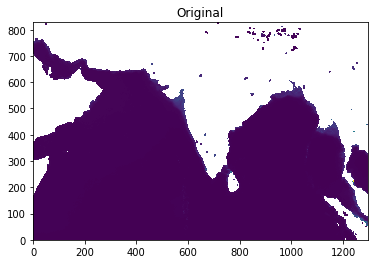

In [6]:
plt.pcolor(ds_CHL.mon_chl_mon_clim[0,:,:])
plt.title('Original')

Text(0.5, 1.0, 'Regridded')

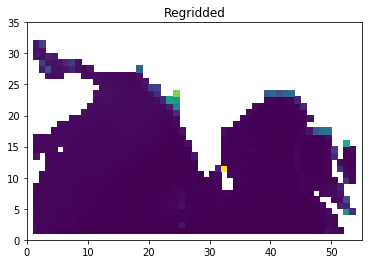

In [7]:
plt.pcolor(ds_out.mon_chl_mon_clim[0,:,:])
plt.title('Regridded')

# SAVE

In [8]:
# delete if already present
if os.path.isfile(outfn):
    os.remove(outfn)

ds_out.to_netcdf(outfn,mode='w',format = "NETCDF4")
ds_out

<xarray.Dataset>
Dimensions:           (lat: 35, lon: 55, month: 12)
Coordinates:
  * month             (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lon               (lon) float32 48.5 49.5 50.5 51.5 ... 100.5 101.5 102.5
  * lat               (lat) float32 -1.5 -0.5 0.5 1.5 ... 29.5 30.5 31.5 32.5
Data variables:
    mon_chl_mon_clim  (month, lat, lon) float64 nan nan nan nan ... nan nan nan